# Imports

In [1]:
import scikeras

In [2]:
import pandas as pd
import numpy as np
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
import joblib
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
# import plotly.offline as pyo

import plotly.io as pio
pio.renderers.default='notebook'

import matplotlib.pyplot as plt
# pyo.init_notebook_mode()

from time import time

In [3]:
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor

In [4]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.python.client import device_lib
# import sklearn.metrics as metrics
# from sklearn.preprocessing import StandardScaler
# import h5py

# Cargar datasets

In [4]:
X_train = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos/X_train_2y.csv', parse_dates=[0], index_col='datetime_utc')
y_train = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos/y_train_2y.csv', parse_dates=[0], index_col='datetime_utc')
X_test = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos/X_test.csv', parse_dates=[0], index_col='datetime_utc')
y_test = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos/y_test.csv', parse_dates=[0], index_col='datetime_utc')
test_data = pd.read_csv('C:/Users/vmore/notebooks/TFM/Modelos eolica/datos/test_data.csv', parse_dates=[0], index_col='datetime_utc')

# 4. MLP keras

In [6]:
start = time()
def get_MLP(hidden_layer_sizes, alpha, meta):
    model = keras.Sequential()
    inp = keras.layers.Input(shape=(meta["n_features_in_"]))
    model.add(inp)
    for hidden_layer_size in hidden_layer_sizes:
        layer = keras.layers.Dense(hidden_layer_size, activation="relu", kernel_regularizer=keras.regularizers.L2(alpha),)
#         model.add(keras.layers.Dropout(dropout))
        model.add(layer)
    out = keras.layers.Dense(6, kernel_regularizer=keras.regularizers.L2(alpha),)
    model.add(out)
#     model.compile(loss=loss, optimizer=compile_kwargs["optimizer"])
    return model

mlp = KerasRegressor(
    model=get_MLP,
    loss="mean_absolute_error",
    optimizer='adam',
#     model__hidden_layer_sizes=(100,),
#     model__dropout=0.2,
    epochs=2000,
    verbose=0,
#     metrics="mean_absolute_error",
    shuffle=False,
    batch_size=64,
)

mlp_pipeline = Pipeline(steps=[('std_sc', StandardScaler()),
                               ('mlp', mlp)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=mlp_pipeline,
                                             transformer=y_transformer)

# param_grid_MLP = {'regressor__mlp__model__hidden_layer_sizes': [(10,), (50,), (100,), (10,10), (50,50), (100,100),],
# #                   'regressor__mlp__model__dropout': [0.1, 0.2, 0.5],
#                   'regressor__mlp__model__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1,],
# #                   'regressor__mlp__batch_size': [8, 16, 32],
#                  }

param_grid_MLP = {'regressor__mlp__model__hidden_layer_sizes': [(10,), (50,), (100,), (10,10), (50,50), (100,100),],
#                   'regressor__mlp__model__dropout': [0.1, 0.2, 0.5],
                  'regressor__mlp__model__alpha': [0.0001],
#                   'regressor__mlp__batch_size': [8, 16, 32],
                 }

# TimeSeries Cross validation
tscv = TimeSeriesSplit(n_splits=2)

# Create the GridSearchCV object
grid_search_MLP = GridSearchCV(inner_estimator, param_grid_MLP, cv=tscv, scoring='neg_mean_absolute_error',
                              n_jobs = -1)

# Fit the GridSearchCV object to the training data
grid_search_MLP.fit(X_train, y_train)

training_time = time() - start
print(training_time/60, ' minutos')

0.1149833877881368  minutos


### Training

In [7]:
best_MLP_score = grid_search_MLP.best_score_
best_MLP_model = grid_search_MLP.best_estimator_

In [8]:
best_MLP_model.regressor_.named_steps['mlp'].model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                130       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 6)                 66        
                                                                 
Total params: 306
Trainable params: 306
Non-trainable params: 0
_________________________________________________________________


In [9]:
grid_search_MLP.best_params_

{'regressor__mlp__model__alpha': 0.0001,
 'regressor__mlp__model__hidden_layer_sizes': (10, 10)}

In [10]:
best_MLP_model

TransformedTargetRegressor(regressor=Pipeline(steps=[('std_sc',
                                                      StandardScaler()),
                                                     ('mlp',
                                                      KerasRegressor(batch_size=-1, epochs=12000, loss='mean_absolute_error', model=<function get_MLP at 0x00000152EBCBA8B0>, model__alpha=0.0001, model__hidden_layer_sizes=(10, 10), optimizer='adam', shuffle=False, verbose=0))]),
                           transformer=StandardScaler())

In [11]:
# best_MLP_model.regressor_.named_steps['mlp'].history_

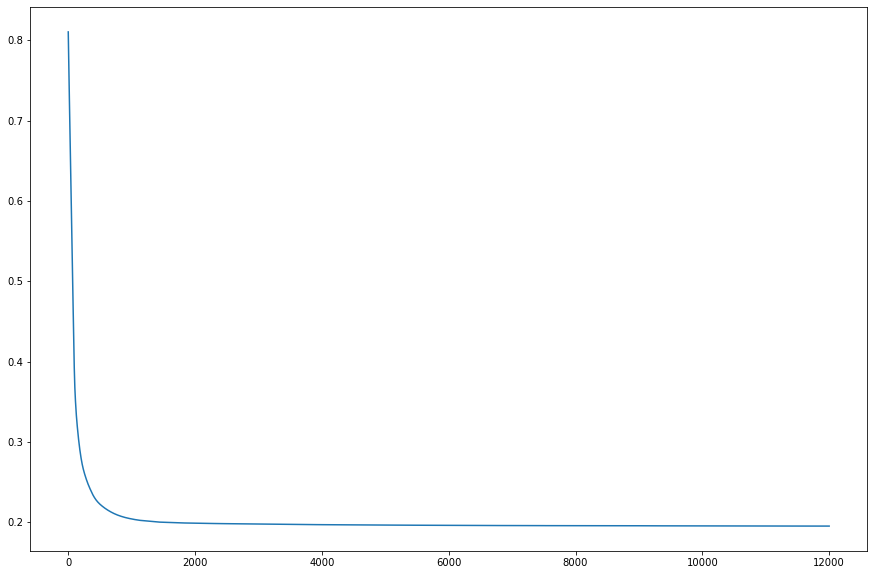

In [12]:
plt.figure(figsize=(15,10))
plt.plot(best_MLP_model.regressor_.named_steps['mlp'].history_['loss'])
# dir(best_MLP_model.regressor_.named_steps['mlp'].history_.values)

### Forecasting

In [13]:
y_pred_MLP = best_MLP_model.predict(X_test)

In [14]:
df_y_pred_MLP = pd.DataFrame(y_pred_MLP, columns=['t+1', 't+2', 't+3', 't+4', 't+5', 't+6'])
df_y_pred_MLP

,t+1,t+2,t+3,t+4,t+5,t+6
0,0.143847,0.135163,0.129183,0.125128,0.124252,0.124581
1,0.140946,0.136421,0.133626,0.132169,0.132711,0.134011
2,0.137780,0.135293,0.134012,0.133676,0.134645,0.136183
3,0.182400,0.195784,0.206139,0.214013,0.218381,0.221259
4,0.178224,0.186145,0.192252,0.196771,0.199332,0.200992
...,...,...,...,...,...,...
8737,0.218258,0.228363,0.235362,0.239156,0.239717,0.238216
8738,0.221312,0.227199,0.230929,0.232045,0.230779,0.228124
8739,0.246970,0.253482,0.257066,0.257603,0.255172,0.251560
8740,0.323359,0.343562,0.357294,0.364849,0.365978,0.363497


In [15]:
MAE_MLP_t1=metrics.mean_absolute_error(y_test['(t+1)'], df_y_pred_MLP['t+1'])
MAE_MLP_t2=metrics.mean_absolute_error(y_test['(t+2)'], df_y_pred_MLP['t+2'])
MAE_MLP_t3=metrics.mean_absolute_error(y_test['(t+3)'], df_y_pred_MLP['t+3'])
MAE_MLP_t4=metrics.mean_absolute_error(y_test['(t+4)'], df_y_pred_MLP['t+4'])
MAE_MLP_t5=metrics.mean_absolute_error(y_test['(t+5)'], df_y_pred_MLP['t+5'])
MAE_MLP_t6=metrics.mean_absolute_error(y_test['(t+6)'], df_y_pred_MLP['t+6'])

In [16]:
print('MAE en t+1: {:2.2%}'.format(MAE_MLP_t1))
print('MAE en t+2: {:2.2%}'.format(MAE_MLP_t2))
print('MAE en t+3: {:2.2%}'.format(MAE_MLP_t3))
print('MAE en t+4: {:2.2%}'.format(MAE_MLP_t4))
print('MAE en t+5: {:2.2%}'.format(MAE_MLP_t5))
print('MAE en t+6: {:2.2%}'.format(MAE_MLP_t6))

MAE en t+1: 0.83%
MAE en t+2: 1.68%
MAE en t+3: 2.49%
MAE en t+4: 3.25%
MAE en t+5: 3.95%
MAE en t+6: 4.57%


MAE en t+1: 0.83%
MAE en t+2: 1.69%
MAE en t+3: 2.50%
MAE en t+4: 3.27%
MAE en t+5: 3.97%
MAE en t+6: 4.60%

# Guardar el modelo

In [17]:
# best_MLP_model.regressor_.named_steps['mlp'].model_.save('modelos/MLP_scikeras_model.h5')
joblib.dump(best_MLP_model, "modelos/MLP_scikeras_model2.joblib")

INFO:tensorflow:Assets written to: C:\Users\vmore\AppData\Local\Temp\tmpwfs5tanv\assets


['modelos/MLP_scikeras_model2.joblib']

# Cargar el modelo

In [18]:
# loaded_MLP = keras.models.load_model('modelos/MLP_scikeras_model.h5')
# loaded_MLP = joblib.load("modelos/MLP_scikeras_model2.joblib")

In [19]:
# y_pred_MLP_loaded = loaded_MLP.predict(X_test)

In [20]:
# y_pred_MLP_loaded

In [21]:
# loaded_MLP.summary()